# Кластеризация пользователей по целям

Задача: Сегментировать пользователей на группы (например, "потенциальные покупатели", "случайные посетители").

Предполагаемые фичи:


*   Посещенные страницы (категории товаров/услуг)
*   Наличие и количество регистраций


Задача кластеризации пользователей может быть полезной для бизнеса. Так можно среди всех посетителей сайта выделить группы потенциальных покупателей, понять, что они чаще всего ищут на сайте, что их привлекает, какие услуги им можно предлагать. При обнаружении таких посетителей сайта можно таргетно предлагать им определенные услуги, скидки и тд, чтобы еще больше привлечь их.

Задачи:


1.   Провести EDA
2.   Определить фичи, подходящие для кластеризации
3. Использовать DBSCAN/K-Means




## Разведка данных

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score

In [4]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/ds_intro_web_yandex_metrika_data.parquet.gzip")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332523 entries, 0 to 332522
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype                                
---  ------               --------------   -----                                
 0   visitID              332523 non-null  uint64                               
 1   date                 332523 non-null  datetime64[ms]                       
 2   dateTime             332523 non-null  datetime64[ms, pytz.FixedOffset(180)]
 3   dateTimeUTC          332523 non-null  datetime64[ms, pytz.FixedOffset(180)]
 4   isNewUser            332523 non-null  uint8                                
 5   startURL             332523 non-null  string                               
 6   endURL               332523 non-null  string                               
 7   pageViews            332523 non-null  int32                                
 8   visitDuration        332523 non-null  uint32                              

In [6]:
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,operatingSystemRoot,operatingSystem,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 19:09:14+03:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,android,android_10,yandex_browser,nan,nan,nan,nan,nan,False,0
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 20:16:58+03:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,ios_double,ios17,safari_mobile,nan,nan,nan,nan,nan,False,0
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 20:30:01+03:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,windows,windows10,chrome,nan,nan,nan,nan,nan,False,0
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 22:35:11+03:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,android,android_14,yandexsearch,nan,nan,nan,nan,nan,False,0
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 18:44:59+03:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,android,android_10,chromemobile,nan,nan,nan,nan,nan,False,0


# Предобработка данных

In [7]:
df.isnull().sum()

,0
visitID,0
date,0
dateTime,0
dateTimeUTC,0
isNewUser,0
startURL,0
endURL,0
pageViews,0
visitDuration,0
bounce,0


В данных нет очевидных пропусков. Однако, пропуски могут быть закодированы по-другому. Проверим это дургим способом:

In [8]:
# Проверка на пустые строки и пробелы
def find_hidden_nulls(df):
    null_report = df.applymap(
        lambda x:
        (isinstance(x, str) and (x.strip() == "" or x.lower() in ["null", "na", "none", "nan"])
    ))
    return null_report

hidden_nulls = find_hidden_nulls(df)
print(hidden_nulls.sum())

<ipython-input-8-5b422e7c5393>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  null_report = df.applymap(


visitID                     0
date                        0
dateTime                    0
dateTimeUTC                 0
isNewUser                   0
startURL                    0
endURL                      0
pageViews                   0
visitDuration               0
bounce                      0
regionCountry            2314
regionCity              84926
clientID                    0
counterUserIDHash           0
referer                 73044
lastTrafficSource           0
mobilePhone            120644
operatingSystemRoot       163
operatingSystem           163
browser                    15
UTMCampaign            276527
UTMContent             281023
UTMMedium              276521
UTMSource              276763
UTMTerm                285086
registration_left           0
total_regs                  0
dtype: int64


Пропуски все-таки есть, причем видно, что пропуски именно в текстовых данных. Поэтому можно заменить их дефолтным значением "Unknown"

In [9]:
columns_to_fix = ['regionCountry', 'regionCity', 'referer', 'mobilePhone', 'operatingSystemRoot',
                  'operatingSystem', 'browser', 'UTMCampaign', 'UTMContent', 'UTMMedium',
                  'UTMSource', 'UTMTerm']

for column in columns_to_fix:
    df[column] = df[column].replace(["", "null", "na", "none", "nan"], "Unknown")

Изменим столбец dateTimeUTC, чтобы он показывал именно время UTC

In [10]:
df['dateTimeUTC'] = df['dateTimeUTC'].dt.tz_convert('UTC')

Заменим значения в столбце "registration_left" с булевых True, False на бинарные 1 и 0

In [11]:
df['registration_left'] = df['registration_left'].astype(int)

### Создание новых полезных признаков

День недели:

In [12]:
df['day_of_week_num'] = df['date'].dt.dayofweek

In [13]:
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,operatingSystem,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs,day_of_week_num
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 16:09:14+00:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,android_10,yandex_browser,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,5
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 17:16:58+00:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,ios17,safari_mobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,5
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 17:30:01+00:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,windows10,chrome,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,5
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 19:35:11+00:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,android_14,yandexsearch,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,5
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 15:44:59+00:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,android_10,chromemobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,5


In [14]:
df['day_of_week_num'] = df['day_of_week_num'] + 1
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,operatingSystem,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs,day_of_week_num
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 16:09:14+00:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,android_10,yandex_browser,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 17:16:58+00:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,ios17,safari_mobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 17:30:01+00:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,windows10,chrome,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 19:35:11+00:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,android_14,yandexsearch,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 15:44:59+00:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,android_10,chromemobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6


Выходной:

In [15]:
df['IsWeekend'] = df['day_of_week_num'].isin([6, 7])
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs,day_of_week_num,IsWeekend
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 16:09:14+00:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,yandex_browser,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6,True
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 17:16:58+00:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,safari_mobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6,True
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 17:30:01+00:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,chrome,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6,True
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 19:35:11+00:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,yandexsearch,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6,True
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 15:44:59+00:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,chromemobile,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,6,True


Время суток:

In [16]:
df['hour'] = df['dateTime'].dt.hour


def hour_to_time_of_day(hour):
  if 0 <= hour <= 5:
    return "Night"
  elif 5 < hour <= 12:
    return "Morning"
  elif 12 < hour < 18:
    return "Day"
  elif 18 <= hour < 24:
    return "Evening"


df['time_of_day'] = df['hour'].apply(hour_to_time_of_day)

In [17]:
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs,day_of_week_num,IsWeekend,hour,time_of_day
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 16:09:14+00:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,Unknown,Unknown,Unknown,Unknown,0,0,6,True,19,Evening
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 17:16:58+00:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,Unknown,Unknown,Unknown,Unknown,0,0,6,True,20,Evening
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 17:30:01+00:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,Unknown,Unknown,Unknown,Unknown,0,0,6,True,20,Evening
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 19:35:11+00:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,Unknown,Unknown,Unknown,Unknown,0,0,6,True,22,Evening
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 15:44:59+00:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,Unknown,Unknown,Unknown,Unknown,0,0,6,True,18,Evening


Продолжительность визита в минутах

In [18]:
df['visitDuration_mins'] = round(df['visitDuration'] / 60, 2)
df.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs,day_of_week_num,IsWeekend,hour,time_of_day,visitDuration_mins
0,4930130390218965245,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 16:09:14+00:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,Unknown,Unknown,Unknown,0,0,6,True,19,Evening,0.00
1,4931195681883816238,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 17:16:58+00:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,Unknown,Unknown,Unknown,0,0,6,True,20,Evening,5.58
2,4931400781901332597,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 17:30:01+00:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,Unknown,Unknown,Unknown,0,0,6,True,20,Evening,0.32
3,4933369587684344107,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 19:35:11+00:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,Unknown,Unknown,Unknown,0,0,6,True,22,Evening,0.25
4,4929748909394231354,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 15:44:59+00:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,Unknown,Unknown,Unknown,0,0,6,True,18,Evening,0.02


# Расчет метрик

**Общее количество визитов**

In [19]:
visits_num = len(df)
print(f"Всего визитов: {visits_num}")

Всего визитов: 332523


**Общее количество уникальных пользователей**

In [20]:
uniq_users_num = df['clientID'].nunique()
print(f"Уникальных пользователей: {uniq_users_num}")

Уникальных пользователей: 216548


**Процент новых пользователей**

In [21]:
NewUsers_perc = 100 * uniq_users_num / visits_num
print(f"Процент новых пользователей: {NewUsers_perc:.2f}%")

Процент новых пользователей: 65.12%


**Среднее количество просмотренных страниц на визит**

In [22]:
avg_pageViews = df['pageViews'].mean()
print(f"Среднее количество просмотренных страниц за визит: {avg_pageViews:.0f}")

Среднее количество просмотренных страниц за визит: 2


In [23]:
grouped_avg = df.groupby('isNewUser')['pageViews'].mean()
print(grouped_avg)

isNewUser
0    2.647398
1    1.588787
Name: pageViews, dtype: float64


В среднем пользователи при первом входе на сайт смотрят меньше вкладок, чем при последующих

**Средняя продолжительность визита**

In [24]:
avg_visitDuration = df['visitDuration_mins'].mean()
print(f"Среднее значение: {avg_visitDuration:.1f} мин")

Среднее значение: 4.9 мин


**Процент отказов:**

In [26]:
unique_users_bounc = df.groupby('clientID')['bounce'].max()
bounc_perc = unique_users_bounc.mean() * 100
print(f"Процент отказов: {bounc_perc:.2f}%")

Процент отказов: 22.27%


**Процент регистраций:**

In [27]:
unique_users_registration = df.groupby('clientID')['registration_left'].max()
reg_left_perc = unique_users_registration.mean() * 100

print(f"Процент уникальных пользователей с регистрацией: {reg_left_perc:.2f}%")

Процент уникальных пользователей с регистрацией: 0.53%


# Анализ распределений по категориям

## По времени

<Axes: title={'center': 'Динамика посещений по дням'}, xlabel='day_of_week_num'>

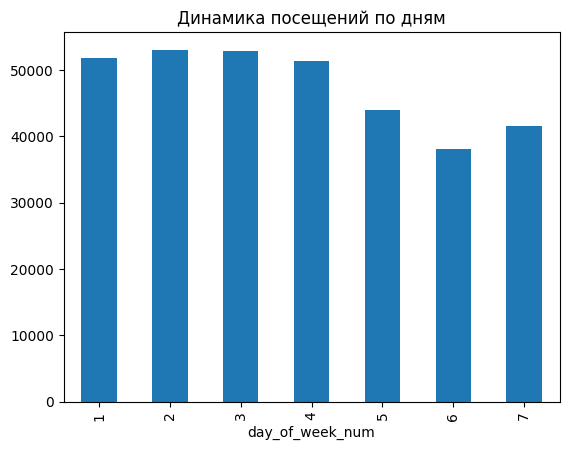

In [25]:
daily_visits = df['day_of_week_num'].value_counts()
daily_visits = daily_visits.sort_index()
daily_visits.plot(kind='bar', title='Динамика посещений по дням')

Больше всего людей поещает сайт в будние дни с понедельника по пятницу. В выходные количество посетителей снижается

<Axes: title={'center': 'Конверсия по дням недели'}, xlabel='day_of_week_num'>

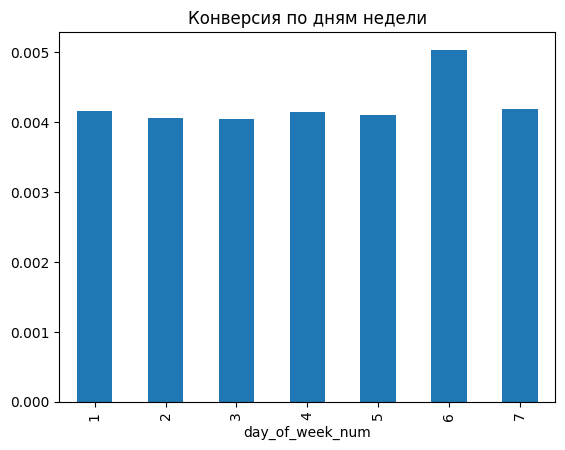

In [26]:
# Конверсия по дням недели
(df.groupby('day_of_week_num')['registration_left']
   .mean()
   .sort_index()
   .plot(kind='bar', title='Конверсия по дням недели'))

При этом, конверсия выше в субботу и воскресенье. Это может быть связано с тем, что по будням у людей меньше времени, и они успевают только просматривать информацию, а свои контакты оставляюи, когда появляется время.

<Axes: title={'center': 'Динамика посещений по времени суток'}, xlabel='time_of_day'>

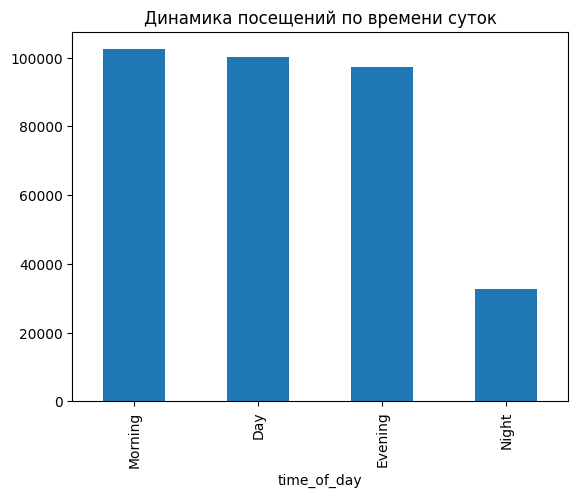

In [27]:
time_of_visit = df['time_of_day'].value_counts()
time_of_visit.plot(kind='bar', title='Динамика посещений по времени суток')

<Axes: title={'center': 'Конверсия по времени суток'}, xlabel='time_of_day'>

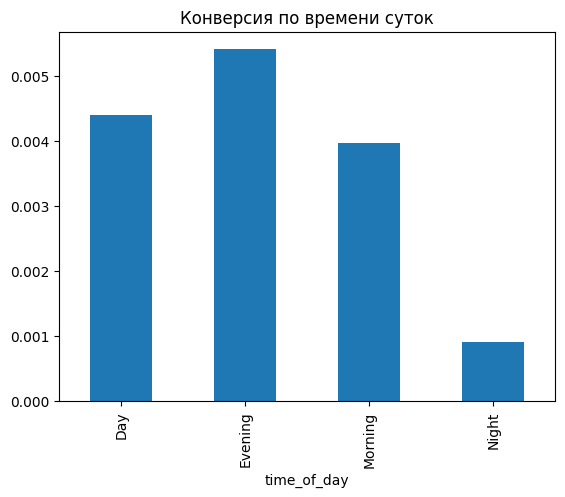

In [28]:
# Конверсия по времени суток
(df.groupby('time_of_day')['registration_left']
   .mean()
   .sort_index()
   .plot(kind='bar', title='Конверсия по времени суток'))

Заходят люди чаще всего утром, но конверсия выше всего вечером. Возможно, тут таккая же ситуация, что и с днями недели. Вечером у людей больше времени

## По устройствам

In [29]:
df['operatingSystemRoot'].value_counts()

,count
operatingSystemRoot,
android,163898
windows,95060
ios_double,63294
macos,7226
gnu_linux,2867
Unknown,163
google_chrome_os,9
tizen,3
firefox_os,2


<Axes: title={'center': 'Доля операционных систем'}, xlabel='operatingSystemRoot'>

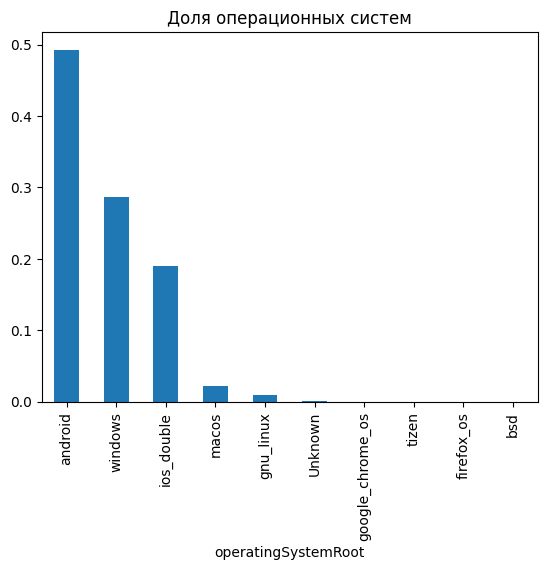

In [30]:
# Распределение по ОС
operatingSystems_perc = df['operatingSystemRoot'].value_counts(normalize=True)
operatingSystems_perc.plot(kind='bar', title='Доля операционных систем')

Почти половина пользователей заходит с телефонов на базе андроид. Примерно 30% используют компьютер с Windows и около 20% заходят с айфонов. Пользователей маков около 2%, а с линукса заходят порядка 1% пользователей. Составляющая других пользователей стремится к нулю.


<Axes: title={'center': 'Процент отказов по ОС'}, xlabel='operatingSystemRoot'>

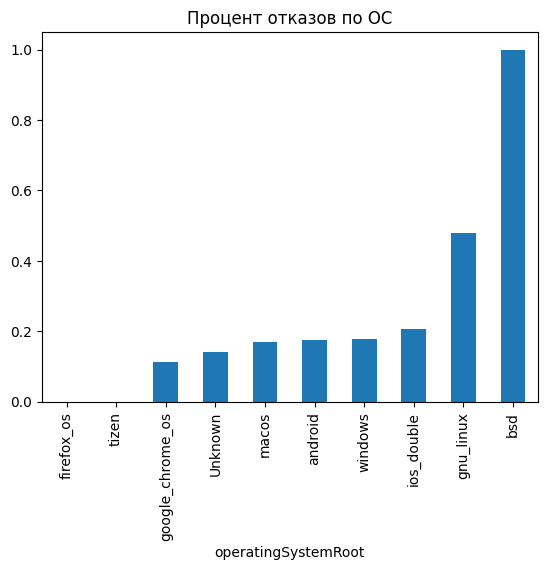

In [31]:
# Отказы по устройствам
(df.groupby('operatingSystemRoot')['bounce']
   .mean()
   .sort_values()
   .plot(kind='bar', title='Процент отказов по ОС'))

* Больше всего отказов с устройств на специфических ОС, таких как linux и bsd. Процент пользователей с такими системами крайне мал. Вполне возможно, что сайт не очень адаптирован под такие системы.
* Процент отказов пользователей айфонов немного выше, чем пользователей mac, android и windows.

## По браузерам:

<Axes: title={'center': 'Доля браузеров'}, xlabel='browser'>

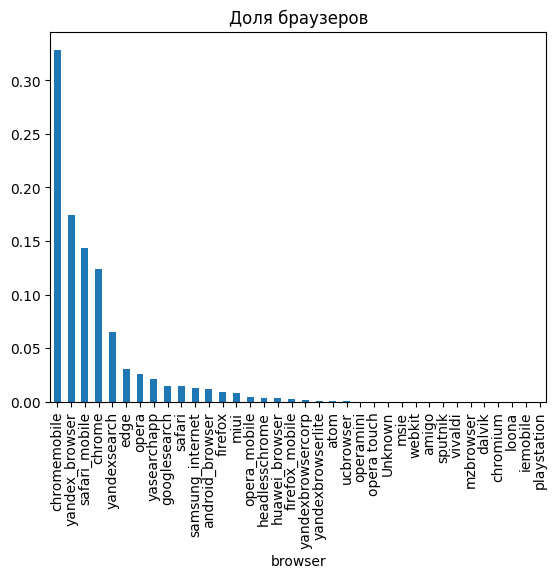

In [32]:
# Распределение по браузерам
operatingSystems_perc = df['browser'].value_counts(normalize=True)
operatingSystems_perc.plot(kind='bar', title='Доля браузеров')

<Axes: title={'center': 'Процент отказов по браузерам'}, xlabel='browser'>

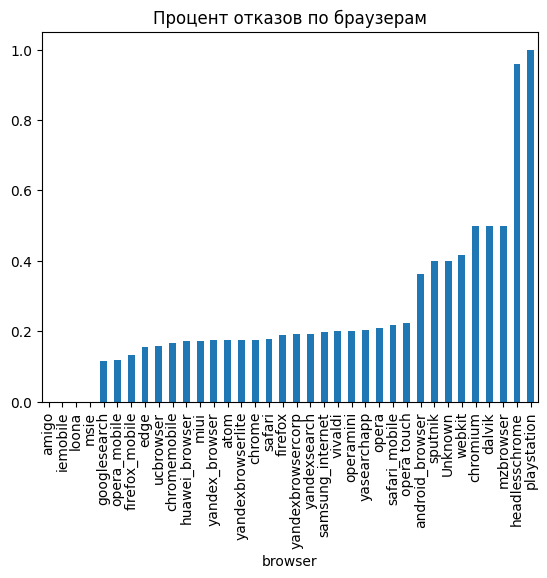

In [33]:
# Отказы по браузерам
(df.groupby('browser')['bounce']
   .mean()
   .sort_values()
   .plot(kind='bar', title='Процент отказов по браузерам'))

Как и в случае с ОС, наибольший процент отказов у наиболее редких и специфичных бразуеров, под которые может быть хуже адаптирован сайт.

## Географический анализ

### По странам

<Axes: title={'center': 'Топ-5 стран по визитам'}, xlabel='regionCountry'>

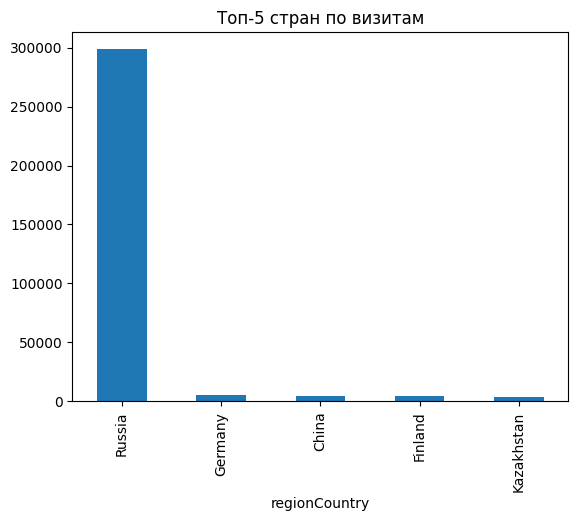

In [34]:
# Топ-5 стран
top_countries = df['regionCountry'].value_counts().head(5)
top_countries.plot(kind='bar', title='Топ-5 стран по визитам')

<Axes: title={'center': 'Конверсия по топ-5 странам'}, xlabel='regionCountry'>

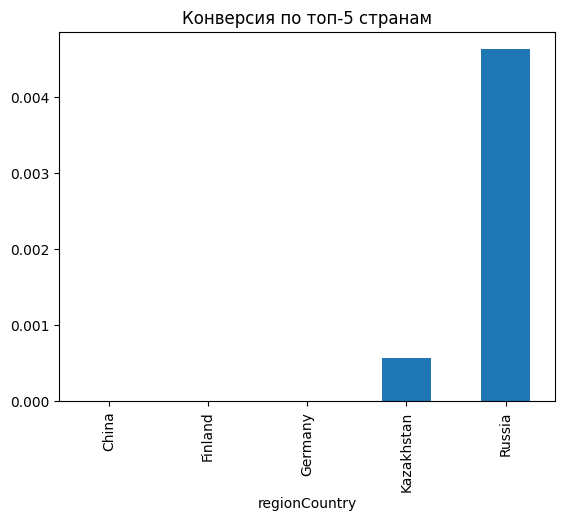

In [35]:
# Конверсия по странам
(df[df['regionCountry'].isin(top_countries.index)]
 .groupby('regionCountry')['registration_left']
 .mean()
 .sort_values()
 .plot(kind='bar', title='Конверсия по топ-5 странам'))

* Конверсия в России наибольшая, по сравнению с другими странами, что коррелирует с наибольшим количеством посетителей.
* Несмотря на то, что по общему количеству посетителей Казахстан проигрывал, по конверсии Казахстан оказался выше всех остальных стран из топ-5, кроме Росии. Это может быть связано с территориальной и культурной близостью и схожестью образовательных программ.

### По городам

<Axes: title={'center': 'Топ-5 городов по визитам'}, xlabel='regionCity'>

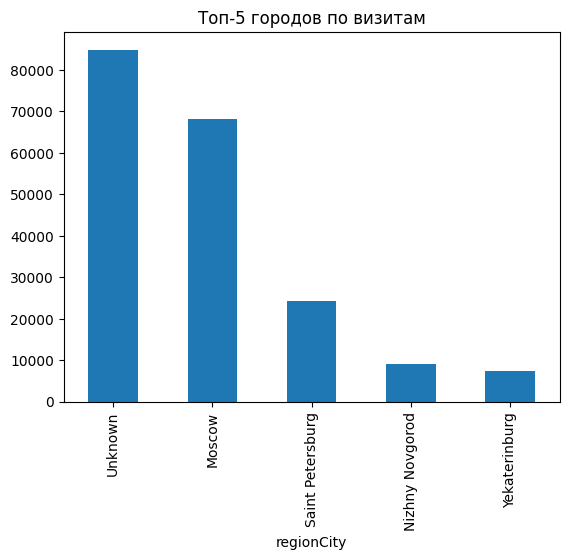

In [36]:
# Топ-5 городов
top_cities = df['regionCity'].value_counts().head(5)
top_cities.plot(kind='bar', title='Топ-5 городов по визитам')

* Большую часть составляют пользователи, город которых не был определен.
* Из известных городов больше всего пользователей из Москвы, Питера, Нижнего Новгорода и Екатеринбурга. Это коррелирует с численностью населения в городах

<Axes: title={'center': 'Конверсия по топ-5 городам'}, xlabel='regionCity'>

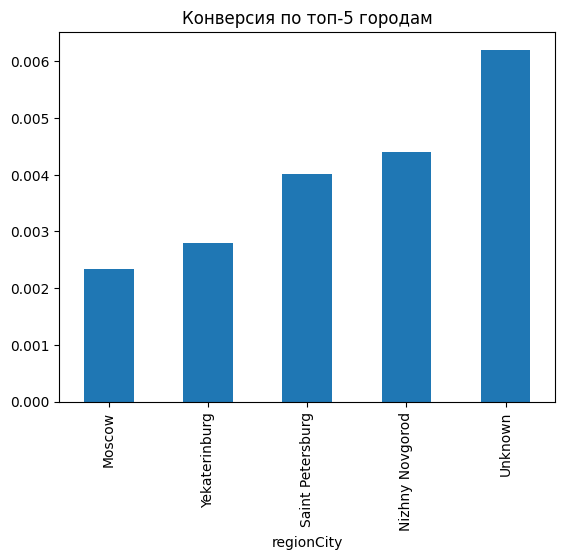

In [37]:
# Конверсия по городам
(df[df['regionCity'].isin(top_cities.index)]
 .groupby('regionCity')['registration_left']
 .mean()
 .sort_values()
 .plot(kind='bar', title='Конверсия по топ-5 городам'))

При этом видно, что конверсия в Нижнем Новгороде и Санкт-Петербурге выше, чем в других городах топа. Может быть в этих городах услуги рекламируются лучше, или меньше альтернатив, по сравнению с Москвой.

## По источнику трафика

<Axes: title={'center': 'Топ-10 источников трафика'}, xlabel='UTMSource'>

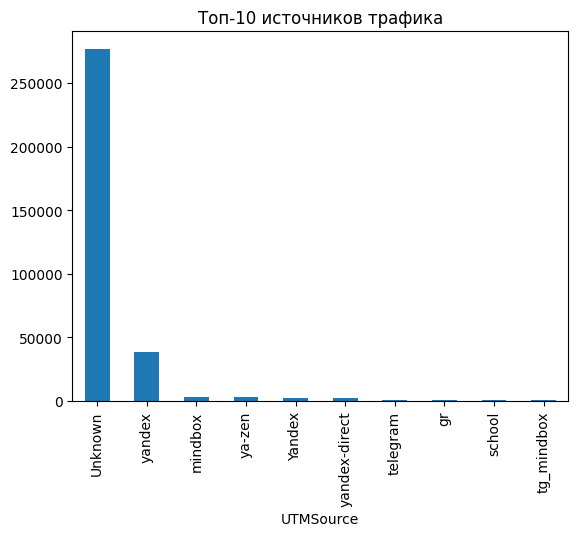

In [28]:
# Топ-10 источников трафика
top_sources = df['UTMSource'].value_counts().head(10)
top_sources.plot(kind='bar', title='Топ-10 источников трафика')

<Axes: title={'center': 'Конверсия по топ-10 источникам'}, xlabel='UTMSource'>

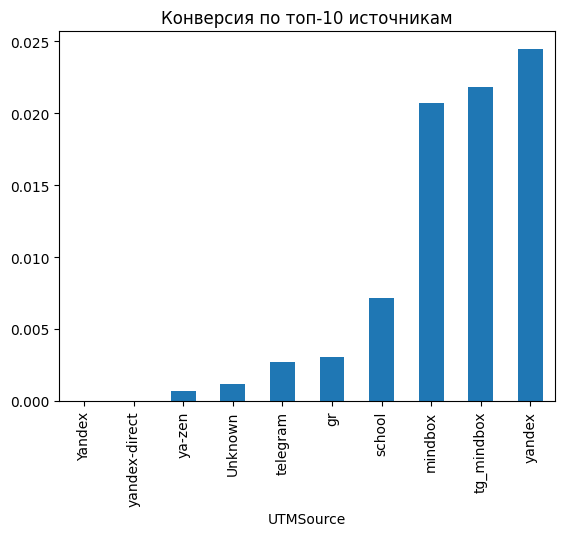

In [29]:
# Конверсия по источникам
(df[df['UTMSource'].isin(top_sources.index)]
 .groupby('UTMSource')['registration_left']
 .mean()
 .sort_values()
 .plot(kind='bar', title='Конверсия по топ-10 источникам'))




Видно, что yandex, tg_mindbox, mindbox являются наиболее эффективными источниками траффика.

Посмотрим на органический и платный траффик

In [31]:
df['lastTrafficSource'].value_counts()

,count
lastTrafficSource,
organic,178846
direct,63800
ad,44055
internal,35449
referral,6805
social,1963
email,1259
messenger,217
recommend,108


In [32]:
paid_sources = ['ad', 'social', 'messenger']  # Платные источники
organic_sources = ['organic', 'direct', 'internal', 'referral', 'email', 'recommend', 'saved']  # Органические источники

df['TrafficType'] = df['lastTrafficSource'].apply(
    lambda x: 'paid' if x in paid_sources else 'organic' if x in organic_sources else 'other'
)

TrafficType
organic    286269
paid        46235
other          19
Name: count, dtype: int64


<Axes: title={'center': 'Количество посещений по типам трафика'}, xlabel='TrafficType'>

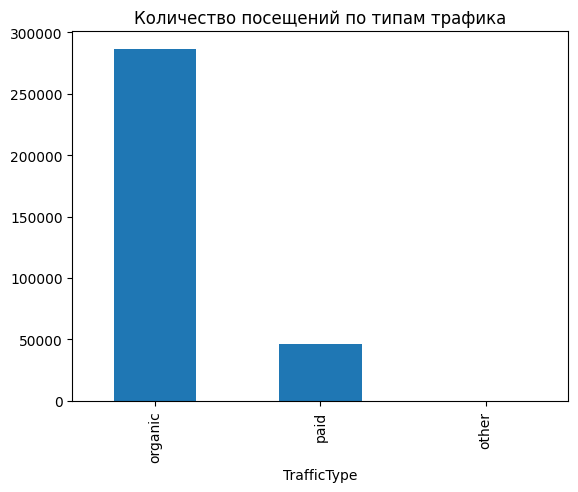

In [33]:
traffic_counts = df['TrafficType'].value_counts()
print(traffic_counts)
traffic_counts.plot(kind='bar', title='Количество посещений по типам трафика')

TrafficType
organic    0.1
other      0.0
paid       2.2
Name: registration_left, dtype: float64


<Axes: title={'center': 'Конверсия по типам трафика'}, xlabel='TrafficType'>

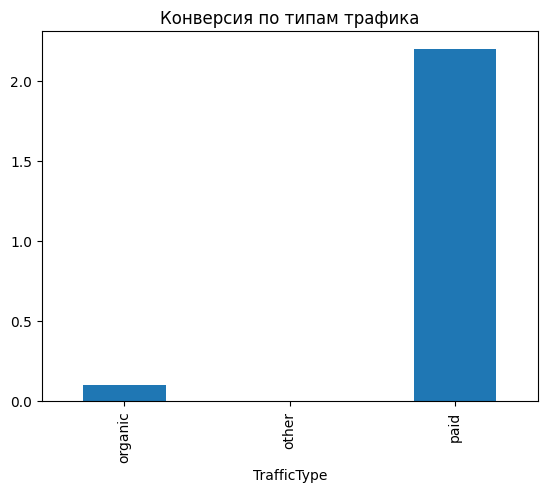

In [34]:
conversion = df.groupby('TrafficType')['registration_left'].mean().mul(100).round(1)
print(conversion)
conversion.plot(kind='bar', title='Конверсия по типам трафика')

Видно, что по органическому траффику приходит больше посетителей, но конверсия выше именно у тех, кто пришел по платному.

#  Кластеризация

## K-Means

In [60]:
user_features = df.groupby('clientID').agg({
    'pageViews': 'mean',
    'visitDuration_mins': 'mean',
    'bounce': 'mean',
    'registration_left': 'max'
}).reset_index()

# Пример результата:
print(user_features.head())

           clientID  pageViews  visitDuration_mins    bounce  \
0                 0   1.380952            0.931905  0.809524   
1        2920608771   1.000000            0.270000  0.000000   
2  1610520826645921   5.000000            9.150000  0.000000   
3  1633792399990137   1.000000            3.400000  0.000000   
4  1635238599161426   1.000000            0.250000  0.000000   

   registration_left  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


In [61]:
data_for_clustering = user_features.drop('clientID', axis=1)

In [62]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

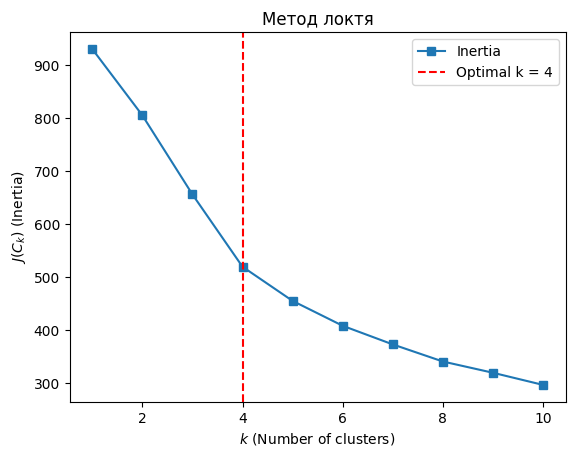

In [63]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(scaled_data)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 11), inertia, marker="s", label="Inertia")
plt.xlabel("$k$ (Number of clusters)")
plt.ylabel("$J(C_k)$ (Inertia)")
plt.title("Метод локтя")

# поиск "локтя" (оптимального k)
# для этого найдем точку, где уменьшение inertia начинает замедляться
# используем вторую производную для нахождения точки перегиба
diff = np.diff(inertia)  # первая производная
diff2 = np.diff(diff)    # вторая производная
optimal_k = np.argmax(diff2) + 2  # +2, так как diff2 имеет длину на 2 меньше

# добавляем вертикальную линию для оптимального k
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.show()

K-Means
3    0.757282
0    0.195527
1    0.041926
2    0.005264
Name: proportion, dtype: float64


<Axes: title={'center': 'Распределение по кластерам'}, xlabel='K-Means'>

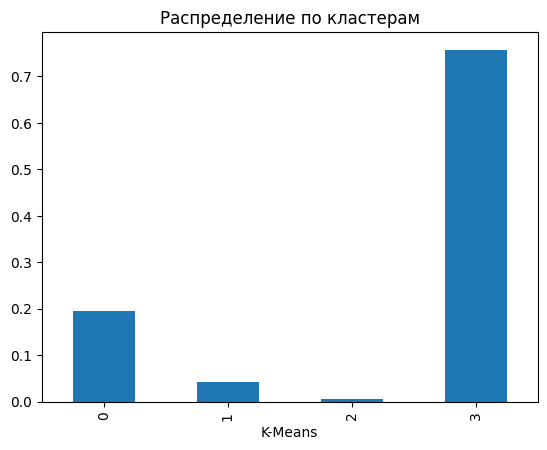

In [71]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_for_clustering['K-Means'] = kmeans.fit_predict(scaled_data)

print(data_for_clustering['K-Means'].value_counts(normalize=True))
data_for_clustering['K-Means'].value_counts(normalize=True).sort_index().plot(kind='bar', title='Распределение по кластерам')

In [66]:
cluster_stats = data_for_clustering.groupby('K-Means').mean()
print(cluster_stats)

         pageViews  visitDuration_mins    bounce  registration_left
K-Means                                                            
0         1.022732            0.100483  0.940921                0.0
1         5.722398           21.544427  0.022504                0.0
2         3.671518            6.465188  0.047956                1.0
3         1.466862            1.590696  0.009243                0.0


In [67]:
silhouette = silhouette_score(scaled_data, data_for_clustering['K-Means'], sample_size=10_000)
print('Силуэт', round(silhouette,3))

Силуэт 0.747


При использовании признаков pageViews, visitDuration_mins, bounce, registration_left удалось выделить 4 кластера.
* 0-й кластер: минимальное время пребывания на сайте и количесвто просмотренных страниц - скорее всего случайный посетитель (около 20% посетителей)
* 1-й кластер: много просмотренных страниц, долгое время пребывания на сайте - потенциальный покупатель, который еще не решился на покупку (около 4% посетителей)
* 2-й кластер: среднее количество просмотренных страниц, и среднее время на сайте + оставлена регистрация - покупатель (0.5% посетителей)
* 3-й кластер: посетители, которые могут пока только присматриваться к продуктам. Они еще не перешли на стадию размышления, как в кластере 1, но еще и не решились на покупку, как в кластере 2 (около 75% посетителей)